In [219]:
import numpy as np
import numba as nb
from numpy.testing import assert_allclose

aos = np.empty((ni, 6))
soa = np.empty((6, ni))
for i in range(6):
    aos[:, i] = np.arange(ni) + i
    soa[i, :] = np.arange(ni) + i

assert_allclose(aos, soa.T)

aos_32 = aos.astype(np.float32)
soa_32 = soa.astype(np.float32)


@nb.njit
def move_aos(aos, step):
    for i in range(len(aos)):
        r = aos[i, :3]
        p = aos[i, 3:]
        pn = np.sqrt(p[0] * p[0] + p[1] * p[1] + p[2] * p[2])
        ps = step / pn
        r += p * ps
    return aos


@nb.njit
def move_aos_improved(aos, step):
    r = aos[:, :3]
    p = aos[:, 3:]
    pn = np.sqrt(p[:,0] * p[:,0] + p[:,1] * p[:,1] + p[:,2] * p[:,2])
    ps = step / pn
    for i in range(3):
        r[:, i] += p[:, i] * ps
    return aos


@nb.njit
def move_soa(soa, step):
    r = soa[:3]
    p = soa[3:]
    pn = np.sqrt(p[0] * p[0] + p[1] * p[1] + p[2] * p[2])
    ps = step / pn
    for i in range(3):
        r[i] += p[i] * ps
    return soa


assert_allclose(move_aos(aos, 3), move_soa(soa, 3).T)
assert_allclose(move_aos_improved(aos, 3), move_soa(soa, 3).T)
assert_allclose(move_aos(aos_32, 3), move_soa(soa_32, 3).T, rtol=1e-6)
assert_allclose(move_aos_improved(aos_32, 3), move_soa(soa_32, 3).T, rtol=1e-6)

fns = ("move_aos", "move_aos_improved", "move_soa")

In [223]:
from timeit import Timer

for bits in (32, 64):
    for ifn, fn in enumerate(fns):
        times = []
        n = np.geomspace(1, 1e6, 15).astype(int)
        for ni in n:
            arg = "aos" if "aos" in fn else "soa"
            dtype = np.float32 if bits == 32 else np.float64
            aos = np.empty((ni, 6), dtype=dtype)
            soa = np.empty((6, ni), dtype=dtype)
            for i in range(6):
                aos[:, i] = np.arange(ni) + i
                soa[i, :] = np.arange(ni) + i
            t = Timer(f"{fn}({arg}, 3)", f"from __main__ import {fn}, {arg}")
            m, dt = t.autorange()
            tmin = min(dt, *t.repeat(3, m))
            times.append(tmin / m)
        plt.plot(n, times, color=f"C{ifn}",
                 ls="-" if bits == 64 else "--",
                 label=f"{bits} bit: {fn}")
plt.legend()
plt.loglog();

In [221]:
import boost_histogram as bh

h = bh.Histogram(bh.axis.StrCategory([], growth=True), bh.axis.Integer(0, 3))

for ifn, fn in enumerate(fns):
    cmds = []
    for line in list(globals()[fn].inspect_asm().values())[0].split("\n"):
        line = line.strip("\t ")
        if line.startswith(".") or line.startswith("__"):
            continue
        if "\t" not in line:
            continue
        cmd = line.split("\t")[0]
        if not cmd.startswith("v"):
            continue
        if cmd.endswith("sd"):
            continue
        cmds.append(cmd)

    h.fill(cmds, ifn)

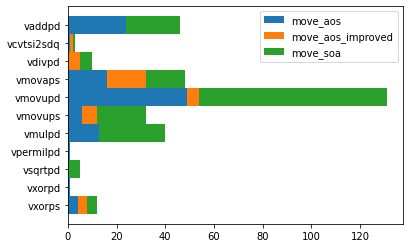

In [222]:
import matplotlib.pyplot as plt

xlabels = []
values = []

for x, v in sorted(zip(h.axes[0], h.values())):
    xlabels.append(x)
    values.append(v)

values = np.array(values)

xe = np.arange(len(xlabels) + 1)
v = 0
for ifn, fn in enumerate((move_aos, move_aos_improved, move_soa)):
    before = v
    v = v + values[:, ifn]
    plt.stairs(v, 1-xe, baseline=before, fill=True, label=fn.__name__, orientation="horizontal")
plt.legend()
plt.gca().yaxis.set_ticks(-np.arange(len(v)) + 0.5)
plt.gca().yaxis.set_ticklabels(xlabels);